In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Analysis functions

### Preprocessing

In [66]:
def get_bdp(): 
    outRate = 2 * 10**6 # 2 Mbps
    rtt = 5 * 4 * 10**-3 # 5ms one link, total return time is 20ms
    bdp = outRate * rtt / 8 # 2Mbps / 8b * 20ms = 5000B
    return bdp

def clean_colums(df):
    bdp = get_bdp()
    df['queue_size'] = df['queue_size'].str.rstrip('B').astype(float)
    df['queue_size'] = df['queue_size'] / bdp
    df['actual_rate_mbps'] = df['actual_rate'] / 1e6  # Convert to Mbps
    df['rate_mbps'] = df['rate'] / 1e6  # Convert to Mbps
    df['rx_rate_mbps'] = df['rx_rate'] / 1e6  # Convert to Mbps
    df['diff_mbps'] =  df['rate_mbps'] - df['rx_rate_mbps'] # df['rate_mbps'] - df['actual_rate_mbps']
    df['error_rate'] = df['diff_mbps'] / df['rx_rate_mbps']
    return df


### Plots

In [67]:
def plot_throughput(df, log=True, y_min=None, y_max=None, keep_fixed=True):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for burst, group in df.groupby('burst'):
        g = group.sort_values('queue_size')
        ax.plot(g['queue_size'], g['rx_rate_mbps'],
                marker='o', label=f'Burst {burst}')

    
    ax.set_xlabel('Queue Size (BDP)')
    ax.set_ylabel('Actual Rate (Mbps)')
    ax.set_title('Actual Rate vs Queue Size for Different Burst Sizes')
    if log:
        ax.set_xscale('log')
    ax.grid(True, which='both', linestyle='--')
    ax.legend()
    
    
    if y_min is not None or y_max is not None:
        # current limits in case one side is left as None
        cur_low, cur_high = ax.get_ylim()
        low  = cur_low  if y_min is None else y_min
        high = cur_high if y_max is None else y_max
        ax.set_ylim(low, high)
        if keep_fixed:
            ax.autoscale(enable=False, axis='y')  # freeze it

    fig.tight_layout()
    plt.show()


In [68]:
def plot_estimated_rate(df, log=True, y_min=None, y_max=None, keep_fixed=True):
    fig, ax = plt.subplots(figsize=(10, 6))

    
    for burst, group in df.groupby('burst'):
        group_sorted = group.sort_values('queue_size')
        ax.plot(group_sorted['queue_size'], group_sorted['rate_mbps'],
                marker='o', label=f'Burst {burst}')

    ax.set_xlabel('Queue Size (BDP)')
    ax.set_ylabel('Estimated Rate (Mbps)')
    ax.set_title('Estimated rate vs Queue Size for Different Burst Sizes')
    if log:
        ax.set_xscale('log')  # Optional: log scale for wide range
    ax.grid(True, which='both', linestyle='--')
    ax.legend()
    
    if y_min is not None or y_max is not None:
        # current limits in case one side is left as None
        cur_low, cur_high = ax.get_ylim()
        low  = cur_low  if y_min is None else y_min
        high = cur_high if y_max is None else y_max
        ax.set_ylim(low, high)
        if keep_fixed:
            ax.autoscale(enable=False, axis='y')  # freeze it

    
    fig.tight_layout()
    plt.show()

In [69]:
def plot_error_rate(df, y_min=None, y_max=None, keep_fixed=True):
    fig, ax = plt.subplots(figsize=(10, 6))

    for burst, group in df.groupby('burst'):
        group_sorted = group.sort_values('queue_size')
        ax.plot(group_sorted['queue_size'], group_sorted['error_rate'],
                marker='o', label=f'Burst {burst}')

    ax.set_xlabel('Queue Size (BDP)')
    ax.set_ylabel('Error Rate')
    ax.set_title('Error Rate vs Queue Size for Different Burst Sizes')
    ax.set_xscale('log')  # Optional: log scale for wide range
    ax.grid(True, which='both', linestyle='--')
    ax.legend()
    
    if y_min is not None or y_max is not None:
        # current limits in case one side is left as None
        cur_low, cur_high = ax.get_ylim()
        low  = cur_low  if y_min is None else y_min
        high = cur_high if y_max is None else y_max
        ax.set_ylim(low, high)
        if keep_fixed:
            ax.autoscale(enable=False, axis='y')  # freeze it
    
    fig.tight_layout()
    plt.show()

In [70]:
def plot_throughput_difference(df, y_min=None, y_max=None, keep_fixed=True):
    fig, ax = plt.subplots(figsize=(10, 6))

    for burst_val, grp in df.groupby('burst'):
        # sort by queue_size so lines connect in order
        grp = grp.sort_values('queue_size')
        ax.plot(grp['queue_size'], grp['diff_mbps'], marker='o', label=f'burst={int(burst_val)}')

    ax.set_xlabel('Queue Size (BDP)')
    ax.set_ylabel('Rate - Actual Rate (Mbps)')
    ax.set_title('Impact of Queue Size & Burst on Rate Difference')
    ax.set_xscale('log')  
    ax.grid(True, which='both', linestyle='--')
    ax.legend(title='Burst Size')
    
    if y_min is not None or y_max is not None:
        # current limits in case one side is left as None
        cur_low, cur_high = ax.get_ylim()
        low  = cur_low  if y_min is None else y_min
        high = cur_high if y_max is None else y_max
        ax.set_ylim(low, high)
        if keep_fixed:
            ax.autoscale(enable=False, axis='y')  # freeze it
    
    fig.tight_layout()
    plt.show()


# Shaping with constant packet size

In [71]:
file = "data/results_shaping.csv"
df_shaping = pd.read_csv(file)
# df_shaping['rx_rate']  = df_shaping['rx_rate'] * 1.33
df_shaping = clean_colums(df_shaping)
df_shaping = df_shaping[df_shaping['queue_size'] < 3]

### Throughput (at Rx)

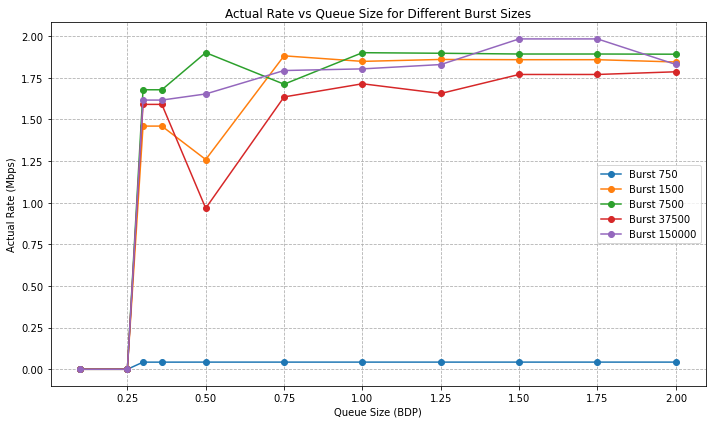

In [72]:
plot_throughput(df_shaping, log=False)

### Estimated policing rate

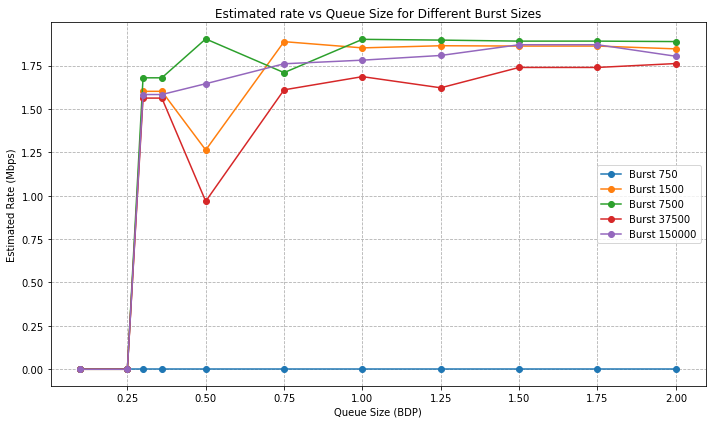

In [73]:
plot_estimated_rate(df_shaping, log=False)

### Error rate

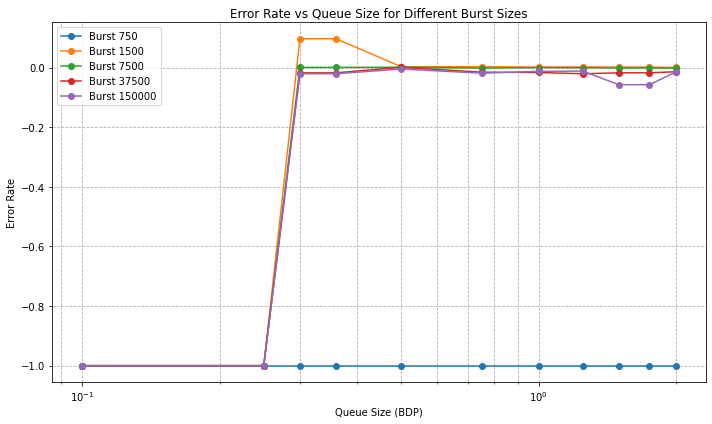

In [74]:
# temp_df = df[df['error_rate'] > -0.2]
plot_error_rate(df_shaping)

### Throughput difference

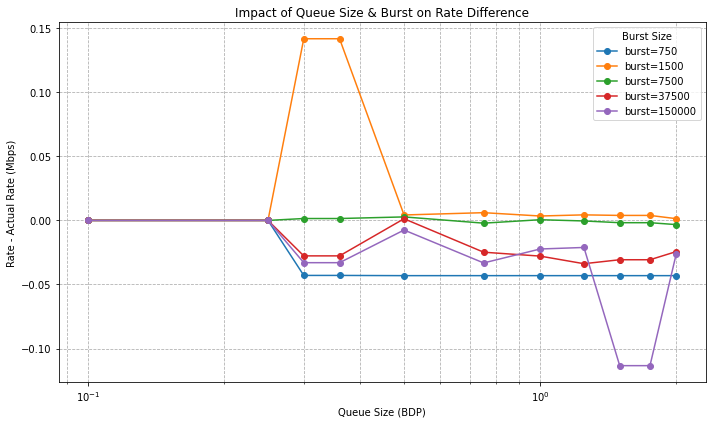

In [75]:
plot_throughput_difference(df_shaping)

# Shaping with variable packet size

In [61]:
file = "data/results_complex-shaping.csv"
df_shaping_variables = pd.read_csv(file)
df_shaping_variables['rx_rate']  = df_shaping_variables['rx_rate'] * 1.25
df_shaping_variables = clean_colums(df_shaping_variables)

### Actual rate and estimated rate

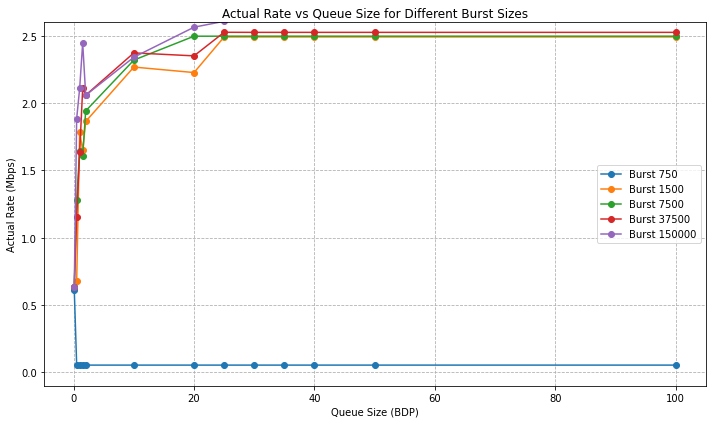

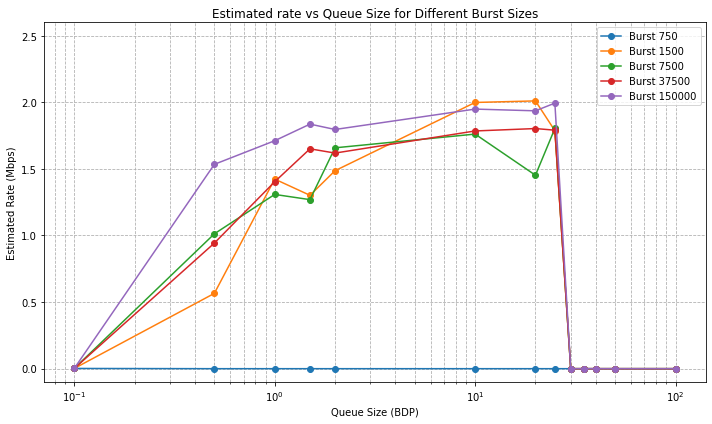

In [62]:
plot_throughput(df_shaping_variables, y_min=-0.1, y_max=2.6)
plot_estimated_rate(df_shaping_variables, y_min=-0.1, y_max=2.6)

### Error rate (relative)

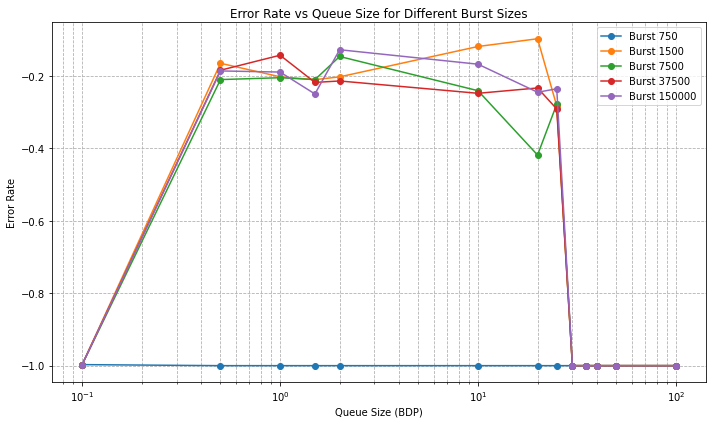

In [21]:
temp_df = df_shaping_variables[df_shaping_variables['error_rate'] > -0.2]
plot_error_rate(df_shaping_variables)

### Raw Difference 

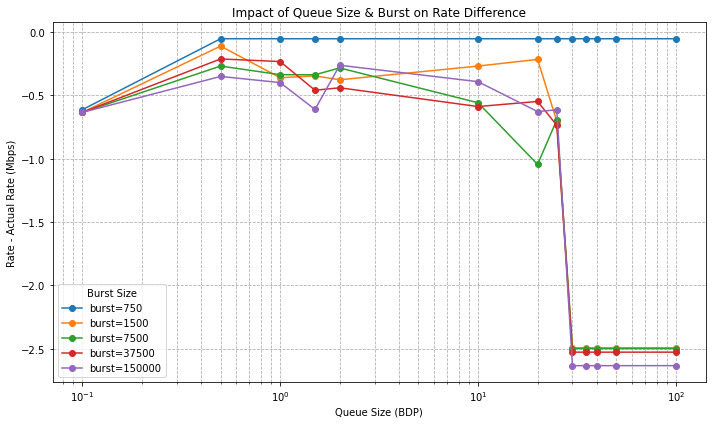

In [22]:
plot_throughput_difference(df_shaping_variables)

# X topology

It is following topology:

```
n4 -----|                   |----- n5
        |                   |
n0 -----n3 (Queue X) ------ n6 ------n1 (TBF)----- n2
   point-to-point links
```

n0 is the main server, n2 is the receiver. n0 sends variable size packets from 1B to 1448B (application layer size)

n4 is the background server, n5 is the background receiver. n4 sends constant size packets from BulkSend application.
n3 is configured as follows:

- burst: same burst as n1
- queue size: 1 packet
- out rate: 20Mbps 

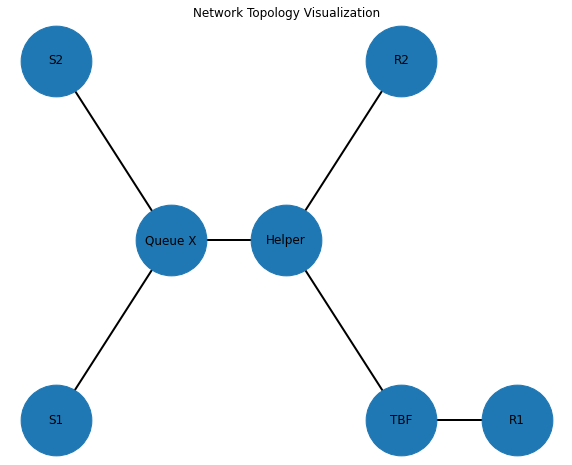

In [23]:
import networkx as nx

# Create the graph
G = nx.Graph()
edges = [
    ('n4', 'n3'),
    ('n5', 'n6'),
    ('n0', 'n3'),
    ('n3', 'n6'),
    ('n6', 'n1'),
    ('n1', 'n2'),
]
G.add_edges_from(edges)

# Define positions for a clear layout
pos = {
    'n3': (0, 0),
    'n0': (-1, -1),
    'n1': (2, -1),
    'n4': (-1, 1),
    'n5': (2, 1),
    'n2': (3, -1),
    'n6': (1, 0),
}

# Draw nodes and edges
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=5000)
nx.draw_networkx_edges(G, pos, width=2)

# Custom labels to include Queue X and TBF
labels = {
    'n0': 'S1',
    'n1': 'TBF',
    'n2': 'R1',
    'n3': 'Queue X',
    'n4': 'S2',
    'n5': 'R2',
    'n6': 'Helper',
}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=12)

# Remove axes for cleaner look
plt.axis('off')
plt.title('Network Topology Visualization')
plt.show()


In [24]:
file = "data/results_xtopo.csv"
df_xtopo = pd.read_csv(file)
df_xtopo = clean_colums(df_xtopo)

### Actual rate and estimated rate

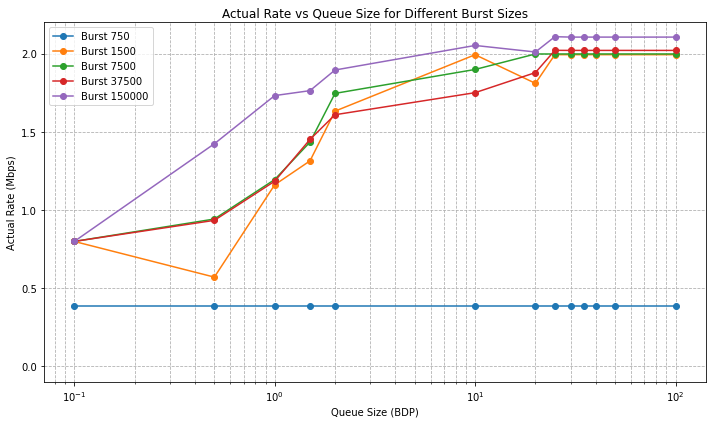

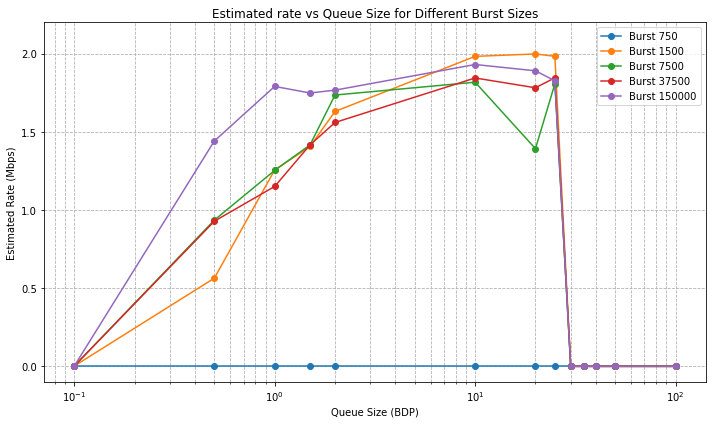

In [25]:
plot_throughput(df_xtopo, y_min=-0.1, y_max=2.2)
plot_estimated_rate(df_xtopo, y_min=-0.1, y_max=2.2)

### Error rate

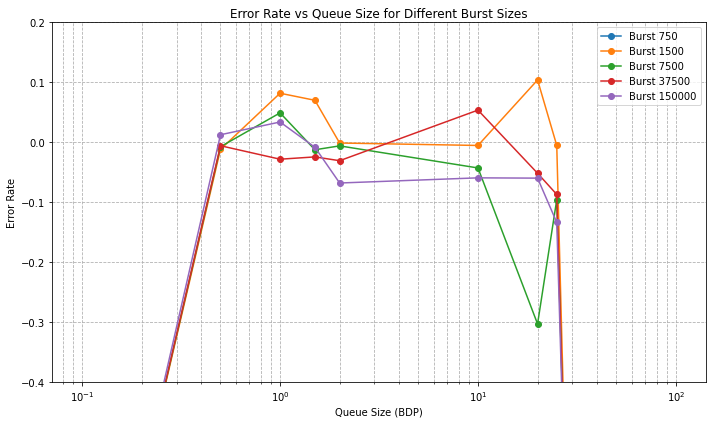

In [26]:
# temp_df = df[df['error_rate'] > -0.2]
plot_error_rate(df_xtopo, y_min=-0.4, y_max=0.2)


### Raw Difference 

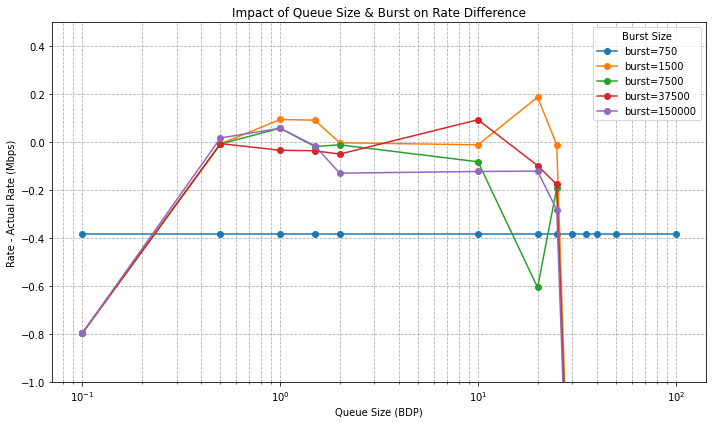

In [27]:
plot_throughput_difference(df_xtopo, y_min=-1, y_max=0.5)

# Shaping with Custom estimation algorithm

Algorithm:

```pseudocode
txs = []
last_loss_t = 0
sum = 0

for packet in packets:
    if packet not lost:
        sum += packet.size
    else:
        txs.append(sum / (packet.time - last_loss_t))
        last_loss_t = packet.time
        sum = 0

estimated_rate = sum(txs) / txs.size
```

In [76]:
file = "data/results_shaping_custom.csv"
df_custom = pd.read_csv(file)
df_custom = clean_colums(df_custom)
df_custom = df_custom[df_custom['queue_size'] < 3]

### Estimated rate

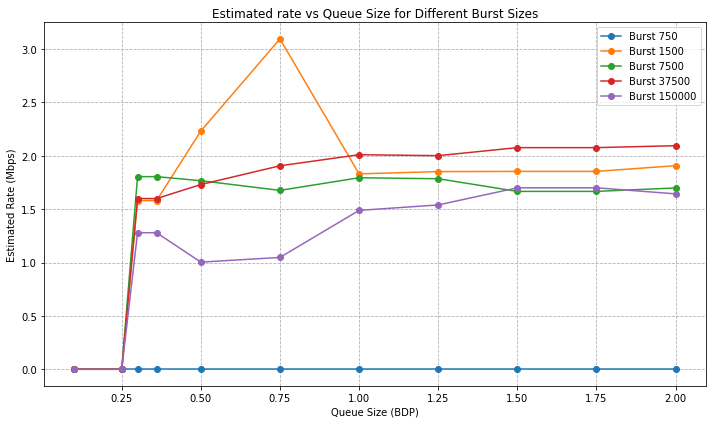

In [77]:
plot_estimated_rate(df_custom, log=False)

# CWND

In [78]:
# file_cwnd = "data/wehe_cwnd_shaping_7500_5000.0B_"
# file_rtt = "data/wehe_rtt_shaping_7500_5000.0B_"
# file_rto = "data/wehe_rto_shaping_7500_5000.0B_"
file_cwnd = "data/wehe_cwnd_shaping_7500_10000.0B_"
file_rtt = "data/wehe_rtt_shaping_7500_10000.0B_"
file_rto = "data/wehe_rto_shaping_7500_10000.0B_"

cwnd = pd.read_csv(file_cwnd, header=None, names=['time', 'cwnd'])
rtt = pd.read_csv(file_rtt, header=None, names=['time', 'delay'])
rtt['used'] = 'rtt'
rto = pd.read_csv(file_rto, header=None, names=['time', 'delay'])
rto['used'] = 'rto'

delays = pd.concat([rtt, rto], ignore_index=True).sort_values('time')
cwnd = cwnd.sort_values('time')
merged = pd.merge_asof(cwnd, delays, on='time', direction='nearest')

merged['throughput'] = merged['cwnd'] / merged['delay']
merged['throughput'] = merged['throughput'] * 8 / 1e6  # Convert to Mbps

merged = merged.rename(columns={'delay': 'metric', 'used': 'source'})

print(merged.head())

       time   cwnd  metric source  throughput
0  0.120009  14480  1.0000    rto    0.115840
1  0.140136  15928  0.0215    rtt    5.926698
2  0.140256  18824  0.0215    rtt    7.004279
3  0.140376  21720  0.0215    rtt    8.081860
4  0.152284  24616  0.0215    rtt    9.159442


In [79]:
# burst == 7500
# queue size == 5'000B

# RTT = 0.02
# df_cwnd['rate'] = df_cwnd['cwnd'] / RTT  * 8 / 1e6 # Mbps
# df_cwnd['cwnd'] = df_cwnd['cwnd'] / 1e3 # KB
# print(df_cwnd['cwnd'])


##### cwnd plot

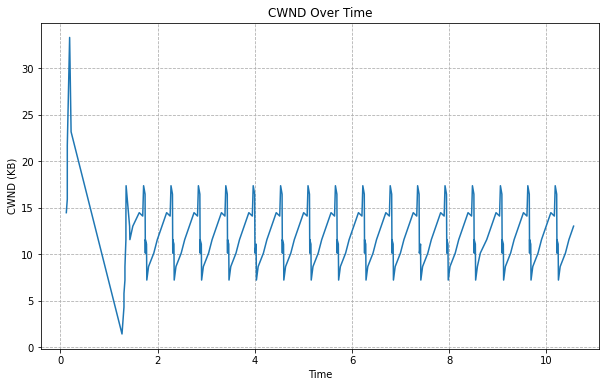

In [80]:
cwnd['cwnd'] = cwnd['cwnd'] / 1e3 # KB


plt.figure(figsize=(10, 6))
plt.plot(cwnd['time'], cwnd['cwnd'])
plt.xlabel('Time')
plt.ylabel('CWND (KB)')
plt.title('CWND Over Time')
plt.grid(True, which='both', linestyle='--')
plt.show()

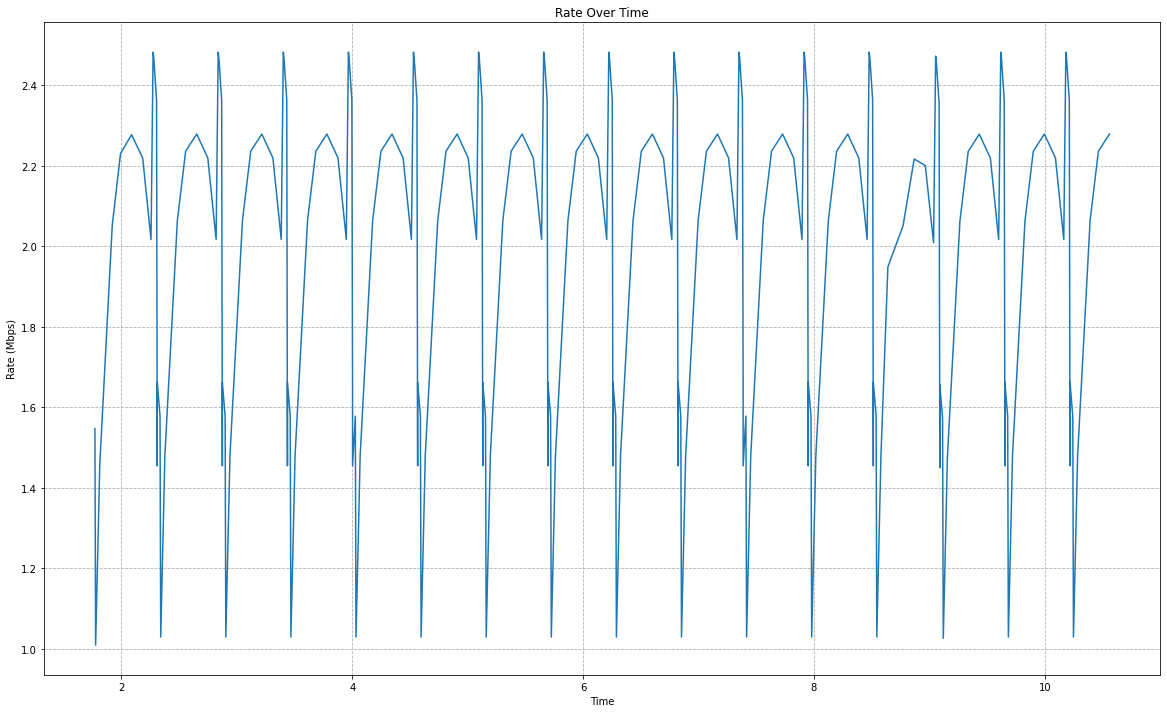

Average Rate: 2.05 Mbps
Min Rate: 1.01 Mbps


In [81]:
plt.figure(figsize=(20, 12))
merged = merged[merged['time'] > 1.75]
plt.plot(merged['time'], merged['throughput'])
plt.xlabel('Time')
plt.ylabel('Rate (Mbps)')
plt.title('Rate Over Time')
plt.grid(True, which='both', linestyle='--')
plt.show()

average_rate = merged['throughput'].mean()
print(f"Average Rate: {average_rate:.2f} Mbps")
min_rate = merged['throughput'].min()
print(f"Min Rate: {min_rate:.2f} Mbps")

# Client side rate estimation exploring

In [105]:
import experimentRun
CLIENT_IDENTIFIER = 'n1-n2-2-0.pcap'

In [116]:
name = "7500_10000.0B"
params = name.split('_')
pcap = f"data/wehe_sim_shaping_{name}_{CLIENT_IDENTIFIER}"
run = experimentRun.ExperimentRun(name, pcap, pcap, "", params)
client = run.get_client_df()

## Cumulative arrival

In [117]:
client = client.sort_values(by='time').reset_index(drop=True)
client['cum_size'] = client['length'].cumsum()
client['cum_size'] = client['cum_size'] / 1e6 * 8  # Convert to Mb

#### Derivative

In [ ]:
client['rate_b_per_s'] = client['cum_size'].diff() / client['time'].diff()
client['rate_b_per_s'] = client['rate_b_per_s'].fillna(0)

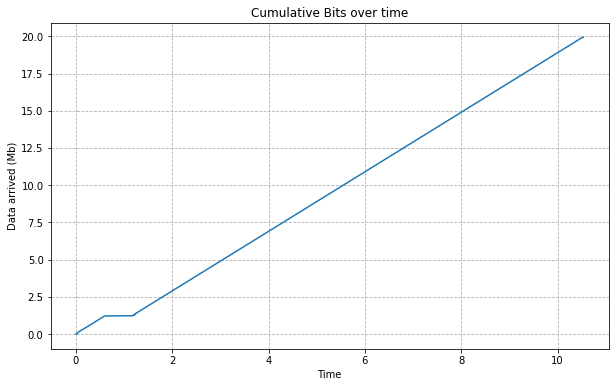

In [119]:
plt.figure(figsize=(10, 6))
plt.plot(client['time'], client['cum_size'])
plt.xlabel('Time')
plt.ylabel('Data arrived (Mb)')
plt.title('Cumulative Bits over time')
plt.grid(True, which='both', linestyle='--')
plt.show()

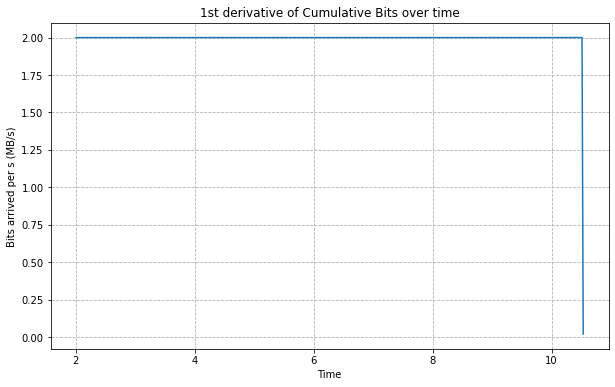

In [ ]:
plt.figure(figsize=(10, 6))
# client = client[client['time'] > 2]
plt.plot(client['time'], client['rate_b_per_s'])
plt.xlabel('Time')
plt.ylabel('Bits arrived per s (MB/s)')
plt.title('1st derivative of Cumulative Bits over time')
plt.grid(True, which='both', linestyle='--')
plt.show()